In [1]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Advanced functions
import scipy.stats as stats

In [4]:
# Read insurance database in pandas
df = pd.read_csv("Data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Three questions to investigate:
1. Do smokers have higher insurance charges than non-smokers?
2. Are men more likely to smoke than women?
3. Do different regions have different charges, on average?

### For each question, we will:
1. 
State your Null Hypothesis and Alternative Hypothes.  i2. s
Select the correct test according to the data type and number of samp.  
3. es
Test the assumptions of your selected t  
4. st.
Execute the selected test, or the alternative test (if you do not meet the assumpt.  
5. ons)
Interpret your p-value and reject or fail to reject your null hypo.  
6. hesis
Show a supporting visualization that helps display the.   result

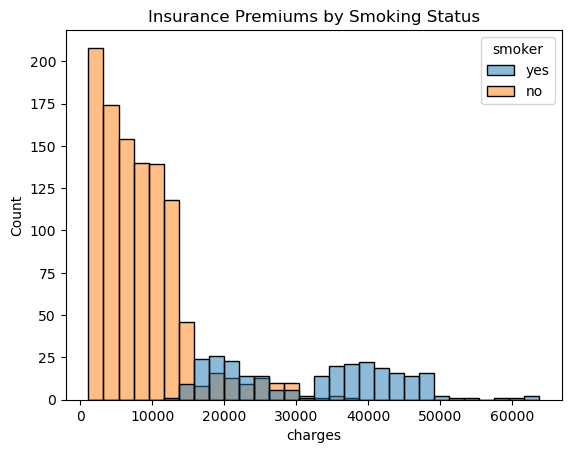

In [6]:
# Visualizing smokers vs nonsmokers 
ax = sns.histplot(data=df, x='charges', hue='smoker')
ax.set_title("Insurance Premiums by Smoking Status");

# Do smokers have higher insurance?

## With checking if smokers have higher insurance charges:
- Null Hypothesis: Smokers do not receive higher insurance charges.
- Alternative Hypothesis: Smokers do receive higher charges.

##### We have a numeric datatype with two samples to test (smokers/non).
##### Therefore, we'll go with 2-sample T-test

In [8]:
# We will make a sample selection and get smoker and nonsmoker charges info
sample = df.sample(n=100, random_state=42)
non = sample.loc[sample['smoker']=='no','charges']
smoker = sample.loc[sample['smoker']=='yes','charges']
print(f'For nonsmokers, n={len(non)}: The average charge is {np.mean(non):.2f}')
print(f'For smokers, n={len(smoker)}: The average charge is {np.mean(smoker):.2f}')

For nonsmokers, n=78: The average charge is 8394.54
For smokers, n=22: The average charge is 32997.31


In [10]:
zscores_n = stats.zscore(non)
outliers_n = abs(zscores_n)>3
np.sum(outliers_n)

2

In [11]:
zscores_s = stats.zscore(smoker)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

0

In [9]:
# Now we will pull results
result = stats.levene(non, smoker)
result

LeveneResult(statistic=18.16256301973094, pvalue=4.667281677378614e-05)

### with p-value far below alpha 0.05, we successfully reject the null hypothesis

In [12]:
## Final t-test, after confirming we meet the assumptions
result = stats.ttest_ind(non, smoker)
result

Ttest_indResult(statistic=-14.041253290885686, pvalue=3.3744096994280633e-25)

In [14]:
## is our result significant
print(f"Significant: {result.pvalue <.05}")

Significant: True


# Are men more likely to smoke than women?

- Null Hypothesis: men aren't more likely...
- Alt Hypothesis: men are more likely...

##### This is a categorical binary problem (men/women : yes/no)
##### With 2 samples we will use Chi-Square method

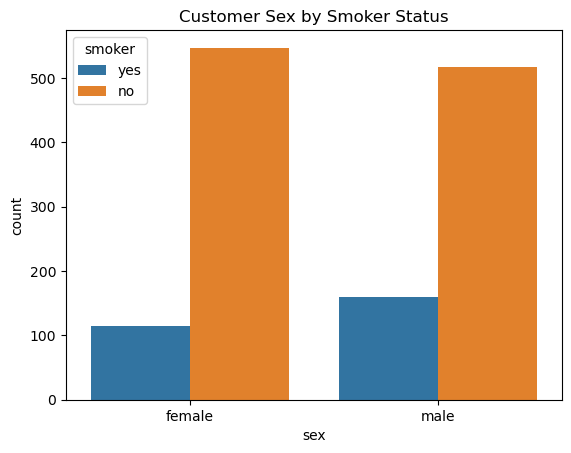

In [16]:
# A countplot can visualize the totals of each sex organized by smoker status
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title("Customer Sex by Smoker Status");

In [17]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [18]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [19]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

##### A p-value less that 0.05 means rejecting the null and concluding there is a correlation between sex and smoking status

# Do different regions have different charges, on average?

- Null: There is no correlation of charges between regions
- Rejection: There is a correlation...

##### Here is a numeric multi-sample problem
##### An ANOVA test allows us to compare means of several samples together

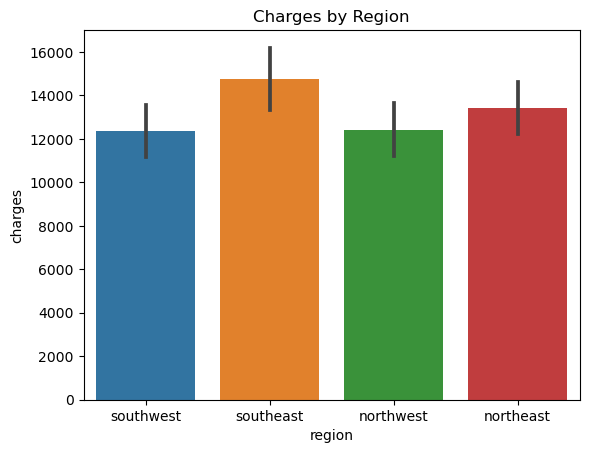

In [22]:
# We will use a barplot to retreive a visual of what to expect from the data
ax = sns.barplot(data=df, x='region', y='charges')
ax.set_title("Charges by Region");

In [23]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [24]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [25]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [26]:
# testing assumption of equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']

In [28]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


##### Using the turkey comparison, there appears to only be a significant statistical difference between the southeast and southwest regions.
##### This is born out by the p-adj being less than 0.05 and reject = True. The mean difference is also greatest between them